# Backtesting the AI Investor
Chapter 5 of the book: "Build Your Own AI Investor"

In [2]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [3]:
from platform import python_version
print(python_version())

3.7.7


# Optional: Train a linear model for backtest
Otherwise train a model in previous notebook, where data will be loaded into this notebook

In [3]:
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
yperf=yperf["Perf"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, yperf, test_size=0.5, random_state=42)

# Save CSVs in case want to see the data.
X_train.to_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv")
X_test.to_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv")
y_train.to_csv("Annual_Stock_Price_Performance_Percentage_train.csv")
y_test.to_csv("Annual_Stock_Price_Performance_Percentage_test.csv")

# Linear
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
    ('linear', LinearRegression())])
pl_linear.fit(X_train, y_train)
y_pred = pl_linear.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_linear.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))
import pickle # To save the fitted model
pickle.dump(pl_linear, open("pl_linear.p", "wb" ))

train mse:  0.4764359938728771
test mse:  0.3112292711726134


In [5]:
type(yperf)

pandas.core.series.Series

Or can use Random Forest

In [95]:
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
yperf=yperf["Perf"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, yperf, test_size=0.5, random_state=42)

# Save CSVs in case want to see the data.
X_train.to_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv")
X_test.to_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv")
y_train.to_csv("Annual_Stock_Price_Performance_Percentage_train.csv")
y_test.to_csv("Annual_Stock_Price_Performance_Percentage_test.csv")

# Linear
from sklearn.ensemble import RandomForestRegressor

rfregressor = RandomForestRegressor(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = rfregressor.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, rfregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))
import pickle # To save the fitted model
pickle.dump(rfregressor, open("rfregressor.p", "wb" ))

train mse:  0.1964461681467214
test mse:  0.32533416873402465


# Read in Train/Test

In [69]:
# X AND Y (no splitting for train/test)
# Financial ratios 
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
# annual stock performances
y=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", index_col=0)
# convert to date
y["Date"], y["Date2"]=pd.to_datetime(y["Date"]), pd.to_datetime(y["Date2"])

# X AND Y (splitting for train/test)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", index_col=0)

y_=pd.DataFrame()
y_=y.loc[y_test.index.values, :]

# convert string to datetime
y_["Date"], y_["Date2"]=pd.to_datetime(y_["Date"]), pd.to_datetime(y_["Date2"])

In [70]:
y_.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
11308,VLGEA,23.430,2011-09-06,3.397350e+05,VLGEA,33.37,2012-09-04,7.775210e+05
7636,NEM,24.025,2014-02-21,5.527504e+08,NEM,25.52,2015-02-23,1.941982e+08
2412,CLFD,13.700,2015-11-25,4.617037e+05,CLFD,19.55,2016-11-25,4.506470e+05
3578,DY,81.190,2017-09-01,5.905135e+07,DY,83.49,2018-09-04,5.703436e+07
6650,LSI,94.060,2015-02-24,1.041348e+07,LSI,106.06,2016-02-24,2.836946e+07


# Z score to account for default chance

In [71]:
# Calculate Altman Z'' scores 1995
def calcZScores(x):
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * x['(CA-CL)/TA']\
    + 3.26 * x['RE/TA']\
    + 6.72 * x['EBIT/TA']\
    + 1.05 * x['Book Equity/TL']
    return Z

In [72]:
z = calcZScores(x)
z.head()

,Z score
0,7.664439
1,7.435224
2,7.538172
3,9.311402
4,8.385200


# Backtest Program

In [73]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData():
    daily_stock_prices=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/us-shareprices-daily/us-shareprices-daily.csv',\
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', daily_stock_prices.shape)
    return daily_stock_prices

In [74]:
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [75]:
def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
#     # Alternative way
#     rows = d[(d["Date"].between(pd.to_datetime(date1),\
#                                 pd.to_datetime(date2) )) \
#                                  & (d["Ticker"]==ticker)]
    rows = d.loc[(d["Date"].values>date1) &\
                 (d["Date"].values<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

In [76]:
def getStockPriceData(ticker, y_, mask, daily_stock_prices, rows):
    date1 = y_[mask][y_[mask]["Ticker"] == ticker]["Date"].values[0]
    date2 = y_[mask][y_[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

In [77]:
def getDataForDateRange(date_Index_New, rows):
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        WeeklyStockDataRows = WeeklyStockDataRows.append(\
          rows.iloc[rows.index.get_loc(I, method="nearest")])
    return WeeklyStockDataRows

In [78]:
def getStockTimeSeries(dateTimeIndex, y_, tickers, mask, daily_stock_prices):
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows=pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_, mask, daily_stock_prices, rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new, rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick]=WeeklyStockDataRows["Close"].values
    return stockRet

In [79]:
def getPortfolioRelativeTimeSeries(stockRet):
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

In [91]:
### First tutorial function reader will write for backtest, will add altmanZ score filter later in chapter. ###

def getPortTimeSeriesForYear(date_starting, y_, x, daily_stock_prices, ml_model_pipeline):
    # get y dataframe as ticker and ticker performance only
    y = getYPerf(y_)
    # Get performance only for time frame we care about,
    # mask original data using the start date
    mask = y_["Date"].between(\
            pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
            pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(x[mask])
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    # Bool list of top stocks
    bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0]) 
    # DatetimeIndex
    dateTimeIndex = pd.date_range(\
                        start=date_starting, periods=52, freq='W')
    # 7 greatest performance stocks of y_pred 
    ticker_list = y[mask].reset_index(drop=True)[bl]["Ticker"].values
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))

    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_, ticker_list, mask, daily_stock_prices)
    # Get DataFrame of relative stock prices from 1st day(or close) and wnole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [96]:
# Function returns to us dataframes of selected stocks/portfolio performance for 1 year.
# y_ is annual stock performances (all backtest years)
# date_starting e.g. '2010-01-01'
# daily_stock_prices is daily(mostly) stock price time series for ALL stocks
def getPortTimeSeriesForYear(date_starting, y_, x, daily_stock_prices, ml_model_pipeline):
    # get y dataframe as ticker and ticker performance only
    y = getYPerf(y_)
    # Get performance only for time frame we care about,
    # mask original data using the start date
    mask = y_["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(x[mask])
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(x)
    # 3.75 is approx. B- rating
    zbl = (z['Z score'][mask].reset_index(drop=True) > 2) 
    y_pred_z = y_pred[zbl]
    # Get bool list of top stocks
    bl = (y_pred_z[0] > y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    # See Z scores
    #print(z['Z score'][mask].reset_index(drop=True)[bl & zbl]) 
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[mask].reset_index(drop=True)[bl & zbl]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    
#     ##### Tutorial code without Z score filtering ##### 
      # bool list of top stocks
#     bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0]) 
      # DatetimeIndex
#     dateTimeIndex = pd.date_range(start=date_starting, periods=52, freq='W')
#     # 7 greatest performance stocks of y_pred 
#     ticker_list = y[mask].reset_index(drop=True)[bl]["Ticker"].values
#     ##### Tutorial code without Z score filtering ##### 
    
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_,\
                                  ticker_list, mask, daily_stock_prices)
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [82]:
def getPortTimeSeries(y_, x, daily_stock_prices, ml_model_pipeline, verbose=True):
    dr=pd.date_range(start='2009-01-01', periods=9, freq='Y') # Date range
    port_perf_all_years = pd.DataFrame()
    ref=1 # relative performance reference.
    for curr_date in dr:
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_, x,\
                                 daily_stock_prices, ml_model_pipeline)
        if verbose:
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        this_year_perf = this_year_perf * ref
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        ref = this_year_perf.iloc[-1]
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

# Run a Backtest

In [37]:
daily_stock_prices=getYRawData()

Reading historical time series stock data, matrix size is:  (5289952, 10)


In [97]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
regressor_pipeline = pickle.load(open("pl_linear.p", "rb" ))
#regressor_pipeline = pickle.load(open("rfregressor.p", "rb" ))
test = getPortTimeSeries(y_, X_test, daily_stock_prices, regressor_pipeline, verbose=True)
print('Performance is: ', 100 * (test["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2009-12-31 00:00:00  is: 21.64 %
With stocks: ['HRI' 'ANDV' 'ARRS' 'IPI' 'DISH' 'PHM' 'NDSN']
HRI Performance was: 38.56 %
ANDV Performance was: 43.26 %
ARRS Performance was: 16.65 %
IPI Performance was: 41.68 %
DISH Performance was: 6.95 %
PHM Performance was: -32.7 %
NDSN Performance was: 37.09 %
---------------------------------------------
Backtest performance for year starting  2010-12-31 00:00:00  is: -14.42 %
With stocks: ['RDC' 'BZH' 'PACB' 'SBH' 'IFON' 'DNB' 'BSET']
RDC Performance was: -26.07 %
BZH Performance was: -57.63 %
PACB Performance was: -83.1 %
SBH Performance was: 32.24 %
IFON Performance was: -34.57 %
DNB Performance was: -12.8 %
BSET Performance was: 81.0 %
---------------------------------------------
Backtest performance for year starting  2011-12-31 00:00:00  is: 56.83 %
With stocks: ['VAC' 'DNB' 'FORM' 'SRPT' 'BZH' 'CCXI' 'PCMI']
VAC Performance was: 101.35 %
DNB Performance was: -0.51 %
FORM Performance was: -12.9 %
SRP

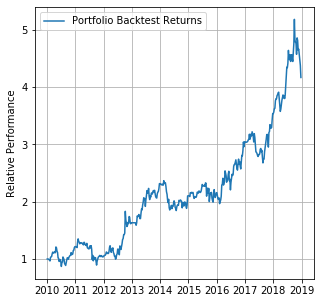

In [98]:
plt.plot(test)
plt.grid()
plt.legend(['Portfolio Backtest Returns'])
plt.ylabel('Relative Performance');

# Investigating The Results

In [41]:
y_small = getYPerf(y_) # y is cut down version of y_ with stock returns only

# Create a boolean mask for the backtest year we are interested in
date = pd.to_datetime('2015-01-01 07:00:00')
mask = y_["Date"].between( pd.to_datetime(date) - pd.Timedelta(days=60), pd.to_datetime(date) + pd.Timedelta(days=60) )
#y_[mask] # Checking the mask works
#x[mask]

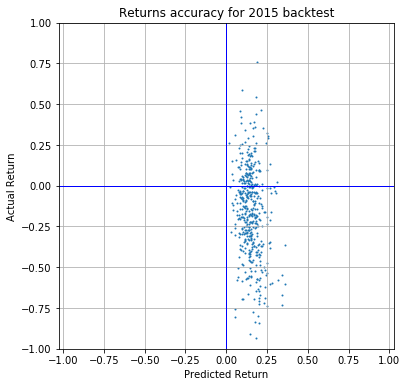

In [59]:
# Load the model pipeline
# can be pl_linear.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p ...
ml_model_pipeline = pickle.load(open("pl_linear.p", "rb" ))
y_pred = ml_model_pipeline.predict(X_test[mask]) # Get stock performance predictions
y_pred = pd.DataFrame(y_pred) # Turn into DataFrame

plt.figure(figsize=(6,6))
# Now output graph.
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
plt.scatter(y_pred[0], y_small[mask]["Perf"], s=1)
# Formatting
plt.grid()
plt.axis('equal')
plt.title('Returns accuracy for {} backtest'.format(date.year))
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')
plt.axvline(c='blue', lw=1)
plt.axhline(c='blue', lw=1)
plt.savefig('result.png')
plt.axis([-1,1,-1,1]);

In [60]:
# Top stocks picked, and predicted performance.
bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

print("\nTop predicted perf. stocks picked are:")
print(y_small[mask].reset_index(drop=True)[bl]["Ticker"])
print("\nTop stocks predicted performance is:")
print(y_pred[bl])


print("\nActual performance was: ")
print(y_small[mask].reset_index(drop=True)[bl])

# Calc Altman Z score:
Z = 3.25 \
+ 6.51 * X_test[mask].reset_index(drop=True)[bl]['(CA-CL)/TA']\
+ 3.26 * X_test[mask].reset_index(drop=True)[bl]['RE/TA']\
+ 6.72 * X_test[mask].reset_index(drop=True)[bl]['EBIT/TA']\
+ 1.05 * X_test[mask].reset_index(drop=True)[bl]['Book Equity/TL']
print('\nZ scores:\n',Z)


Top predicted perf. stocks picked are:
1      CNXR
65     BNFT
166     NAV
219     BXC
224    INVA
284     LEE
395     UIS
Name: Ticker, dtype: object

Top stocks predicted performance is:
            0
1    0.342796
65   0.310343
166  0.344782
219  0.360295
224  0.360158
284  0.314698
395  0.340687

Actual performance was: 
    Ticker      Perf
1     CNXR -0.671378
65    BNFT  0.020316
166    NAV -0.732625
219    BXC -0.601770
224   INVA -0.364440
284    LEE -0.575342
395    UIS -0.545455

Z scores:
 1     -2.000570
65    -4.858631
166    1.229350
219    5.410565
224   -6.243600
284    1.981171
395    1.731922
dtype: float64


In [61]:
# bool list of 7 greatest performance stocks of y_pred 
bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

# See what the performance is of the selection
print("Backtest return is:")
print(y_small[mask]["Perf"].reset_index(drop=True)[bl].values.mean())

Backtest return is:
-0.495813387620907


In [62]:
d = getYRawData()

Reading historical time series stock data, matrix size is:  (5289952, 10)


In [63]:
y_[mask]

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
6650,LSI,94.0600,2015-02-24,1.041348e+07,LSI,106.0600,2016-02-24,2.836946e+07
2608,CNXR,8.4900,2015-02-17,5.751211e+05,CNXR,2.7900,2016-02-16,9.495486e+04
3971,ETM,11.3800,2015-03-02,8.221253e+05,ETM,11.5000,2016-03-01,1.012724e+06
7757,NLS,15.2800,2015-02-26,3.851492e+06,NLS,18.3100,2016-02-26,5.505140e+06
3424,DNOW,22.3500,2015-02-25,4.420258e+07,DNOW,14.9700,2016-02-25,3.979035e+07
...,...,...,...,...,...,...,...,...
5659,INTL,17.8700,2014-12-10,4.878510e+05,INTL,36.9700,2015-12-10,7.959641e+06
8161,ON,12.9100,2015-02-27,9.540835e+07,ON,8.4600,2016-02-29,2.318844e+07
11199,UTX,74.4242,2015-02-05,3.488483e+08,UTX,55.4059,2016-02-05,2.890340e+08
4041,EXAS,23.3900,2015-02-27,6.206490e+07,EXAS,5.7400,2016-02-29,1.880946e+07


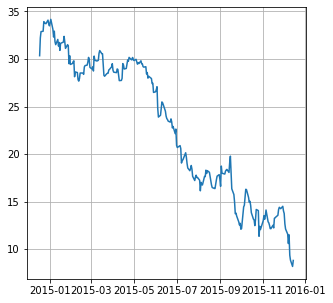

In [56]:
rows = getStockPriceData("NAV", y_, mask, d, rows=pd.DataFrame())
plt.plot(rows["Date"], rows["Close"]) # Adj. Close
plt.grid(True)

In [51]:
rows

,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume
3894771,FMSA,645665,2015-02-18,31.50,31.50,33.950,33.15,33.15,NaN,748796
3894772,FMSA,645665,2015-02-19,32.55,31.00,34.000,33.80,33.80,NaN,721282
3894773,FMSA,645665,2015-02-20,33.85,32.50,34.500,34.15,34.15,NaN,474127
3894774,FMSA,645665,2015-02-23,33.95,31.15,34.250,32.80,32.80,NaN,814672
3894775,FMSA,645665,2015-02-24,33.20,32.35,34.400,33.05,33.05,NaN,512890
...,...,...,...,...,...,...,...,...,...,...
3895016,FMSA,645665,2016-02-08,9.80,9.20,10.500,9.80,9.80,NaN,810348
3895017,FMSA,645665,2016-02-09,9.35,8.65,9.750,9.00,9.00,NaN,599601
3895018,FMSA,645665,2016-02-10,9.00,8.45,9.500,8.70,8.70,NaN,352975
3895019,FMSA,645665,2016-02-11,8.25,7.45,8.925,7.90,7.90,NaN,559372


# See how individual stocks perform
With the program functions used individually

In [52]:
# Make X ticks standard, and grab stock prices as close to those points as possible for each stock (To track performance)
date_range = pd.date_range(start=date, periods=52, freq='W')#DatetimeIndex

# 7 greatest performance stocks of y_pred 
ticker_list = y[mask].reset_index(drop=True)[bl]["Ticker"].values
stockRet = getStockTimeSeries(date_range, y_, ticker_list , mask, daily_stock_prices)

In [53]:
stockRetRel = getPortfolioRelativeTimeSeries(stockRet)

In [54]:
stockRetRel.head()

,CNXR,BNFT,NAV,BXC,INVA,LEE,UIS,Portfolio
2015-01-04 07:00:00,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000
2015-01-11 07:00:00,1.0,1.0,0.968278,1.0,1.0,0.951705,1.0,0.988569
2015-01-18 07:00:00,1.0,1.0,0.959819,1.0,1.0,0.897727,1.0,0.979649
2015-01-25 07:00:00,1.0,1.0,0.951662,1.0,1.0,0.894886,1.0,0.978078
2015-02-01 07:00:00,1.0,1.0,0.891843,1.0,1.0,0.835227,1.0,0.961010


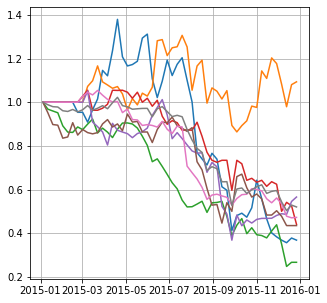

In [55]:
plt.plot(stockRetRel);
plt.grid()

# Now plot backtest with S&P500

volatility of AI investor was:  0.5368839645114541
volatility of S&P 500 was:  0.14107078778110896


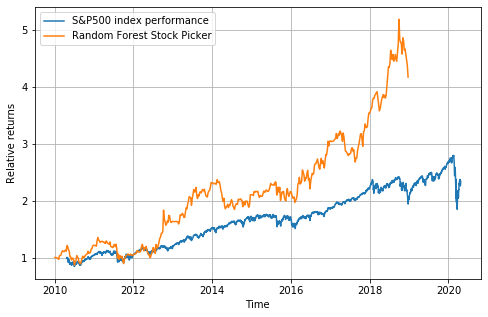

In [99]:
# GSPC.csv taken directly from Yahoo.com is the S&P500.
spy=pd.read_csv("GSPC.csv", index_col='Date', parse_dates=True)
spy['Relative'] = spy["Open"]/spy["Open"][0]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(spy['Relative'])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Relative returns')
plt.legend(['S&P500 index performance', 'Linear Regressor Stock Picker'])
#plt.savefig('spy.png')
print('volatility of AI investor was: ', test['Indexed Performance'].diff().std()*np.sqrt(52))
print('volatility of S&P 500 was: ', spy["SP500"].diff().std()*np.sqrt(52))

In [174]:
spy["SP500"].size

2518